<a href="https://colab.research.google.com/github/kahram-y/first-repository/blob/master/WrapUp/sslife_stockprice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 보험 섹터 대장주 선정 → 시계열 분석 & 예측 실습

import sys
import subprocess

def pip_install(packages):
    import importlib
    for pkg in packages:
        try:
            importlib.import_module(pkg)
        except Exception:
            print(f"Installing {pkg} ...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

# 필요한 라이브러리 (설치 안 된 경우 설치)
pip_install(["yfinance","pandas","numpy","matplotlib","scikit-learn","pmdarima","xgboost","statsmodels","ta"])

# 라이브러리 로드
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import joblib
import datetime
import pmdarima as pm

plt.rcParams["figure.figsize"] = (10,6)

Installing scikit-learn ...
Installing pmdarima ...
Installing ta ...


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [2]:
# ------------- 사용자 설정 ----------------
# 기본 후보 리스트(필요하면 여기에 종목 추가/제거)
# Yahoo/시장에서 한국 주식은 티커 뒤에 ".KS" 또는 ".KQ"를 붙입니다.
candidates = {
    "삼성생명": "032830.KS",
    "삼성화재": "000810.KS",
    "한화생명": "088350.KS",
    "메리츠화재": "000060.KS",
    "DB손해보험": "005830.KS"
}

start_date = "2018-01-01"
end_date = datetime.date.today().strftime("%Y-%m-%d")
forecast_horizon = 30  # 예측 일수 (향후 30거래일)
# ------------------------------------------

In [3]:
# 1) 데이터 수집: 종가 + (가능하면) 시가총액 가져와서 대장주 선정
info_list = {}
price_data = {}

for name, ticker in candidates.items():
    print(f"Downloading {name} ({ticker}) ...")
    t = yf.Ticker(ticker)
    # price (일봉)
    df = t.history(start=start_date, end=end_date, auto_adjust=False)
    if df.empty:
        print(f"Warning: {ticker} 데이터 없음")
        continue
    # 기본 컬럼 통일: Date 인덱스, Adj Close 사용 권장하지만 한국 주식은 adjusted가 복잡할 수 있어 Close도 같이 사용
    df = df[['Open','High','Low','Close','Volume','Dividends','Stock Splits']].copy()
    price_data[name] = df
    # 시가총액 시도(안되는 경우가 있어 safely)
    info = {}
    try:
        info = t.info
        info_list[name] = {
            "longName": info.get("longName"),
            "marketCap": info.get("marketCap")
        }
    except Exception:
        info_list[name] = {"longName": None, "marketCap": None}

ERROR:yfinance:$000060.KS: possibly delisted; no timezone found


In [4]:
# 2) 대장주 선정: 시가총액(max) 기준(정보 없으면 종가*주식수 계산 불가하므로 종가 기준 대체 가능)
market_caps = {n: (info_list[n].get("marketCap") if n in info_list else None) for n in price_data.keys()}
# 가능한 항목만 고려
available_caps = {n:c for n,c in market_caps.items() if c is not None}
if available_caps:
    leader = max(available_caps.items(), key=lambda x:x[1])[0]
else:
    # fallback: 최근 평균 시가(종가)로 선택
    avg_prices = {n:price_data[n]['Close'].tail(60).mean() for n in price_data.keys()}
    leader = max(avg_prices.items(), key=lambda x:x[1])[0]

print(f"\n선정된 대장주: {leader}")


선정된 대장주: 삼성생명


/tmp/ipython-input-1907182141.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Close'].interpolate(method='time', inplace=True)  # 간단 보간
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49340 (\N{HANGUL SYLLABLE SAM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(byte

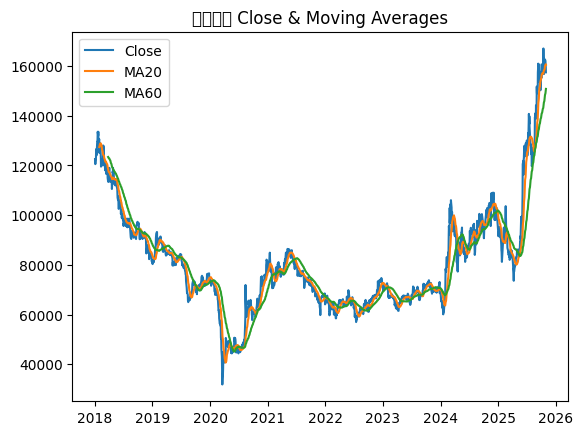

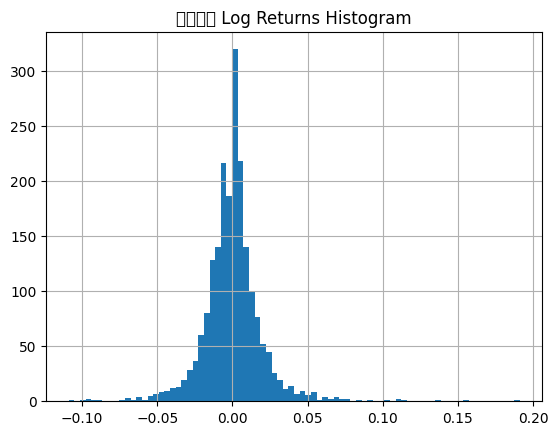

In [5]:
# 3) EDA: 종가, 로그수익률, 이동평균, 변동성
df = price_data[leader].copy()
df.index = pd.to_datetime(df.index)
df = df.asfreq('B')  # 영업일 주기(휴장일은 NaN)
df['Close'].interpolate(method='time', inplace=True)  # 간단 보간

df['log_ret'] = np.log(df['Close']).diff()
df['ret'] = df['Close'].pct_change()
df['MA20'] = df['Close'].rolling(20).mean()
df['MA60'] = df['Close'].rolling(60).mean()
df['vol20'] = df['log_ret'].rolling(20).std() * np.sqrt(252)

# plot price and moving averages
plt.figure()
plt.plot(df['Close'], label='Close')
plt.plot(df['MA20'], label='MA20')
plt.plot(df['MA60'], label='MA60')
plt.title(f"{leader} Close & Moving Averages")
plt.legend()
plt.show()

# plot returns histogram
plt.figure()
df['log_ret'].dropna().hist(bins=80)
plt.title(f"{leader} Log Returns Histogram")
plt.show()

/tmp/ipython-input-1536007424.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stl = STL(df['Close'].fillna(method='ffill'), period=252)  # 연간 주기(대략)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49340 (\N{HANGUL SYLLABLE SAM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from font(s) DejaVu San

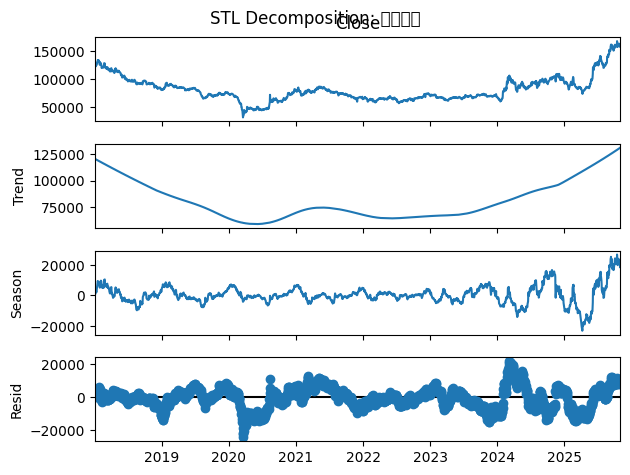

In [6]:
# 4) 시계열 분해 (STL)
stl = STL(df['Close'].fillna(method='ffill'), period=252)  # 연간 주기(대략)
res = stl.fit()
fig = res.plot()
plt.suptitle(f"STL Decomposition: {leader}")
plt.show()

In [7]:
# 5) 예측용 데이터 준비 (머신러닝)
# 사용할 타깃: 다음날 Close (shift -1)
data = df[['Close','ret','log_ret','MA20','MA60','vol20']].copy()

# 기술지표(간단한 추가) - 라그(lag) 및 롤링 통계
for lag in [1,2,3,5,10]:
    data[f'lag_{lag}'] = data['Close'].shift(lag)
for w in [5,10,20]:
    data[f'roll_mean_{w}'] = data['Close'].rolling(w).mean()
    data[f'roll_std_{w}'] = data['Close'].rolling(w).std()

# 타깃 변수
data['target'] = data['Close'].shift(-1)  # 다음 영업일 종가 예측
data = data.dropna()

# train/test split (시간 순)
train_frac = 0.8
train_n = int(len(data)*train_frac)
train = data.iloc[:train_n]
test = data.iloc[train_n:]

X_train = train.drop(columns=['target'])
y_train = train['target']
X_test = test.drop(columns=['target'])
y_test = test['target']

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

Training samples: 1586, Test samples: 397


In [9]:
# 6) 모델 A: 자동 ARIMA (pmdarima)
# ARIMA은 시계열(단일 시리즈)에서 직접 학습
series = df['Close'].dropna()
# train series for ARIMA
arima_train = series.iloc[:int(len(series)*train_frac)]
print("Fitting auto_arima (this may take time)...")
arima_model = pm.auto_arima(arima_train, seasonal=False, suppress_warnings=True, stepwise=True, error_action='ignore')
print("ARIMA order:", arima_model.order)

# forecast with ARIMA for horizon = len(test)
arima_forecast = arima_model.predict(n_periods=len(test))
# align with test index
arima_pred_series = pd.Series(arima_forecast, index=test.index)

Fitting auto_arima (this may take time)...


NameError: name 'pm' is not defined

In [ ]:
# 7) 모델 B: RandomForest (머신러닝 회귀)
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_pred_series = pd.Series(rf_pred, index=X_test.index)

In [11]:
# 8) 평가 함수
def evaluate(y_true, y_pred, name="model"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"{name} -> RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")
    return {"rmse":rmse,"mae":mae,"mape":mape}

print("\nEvaluation on test set:")
res_arima = evaluate(y_test, arima_pred_series, "ARIMA")
res_rf = evaluate(y_test, rf_pred_series, "RandomForest")


Evaluation on test set:


NameError: name 'arima_pred_series' is not defined

NameError: name 'arima_pred_series' is not defined

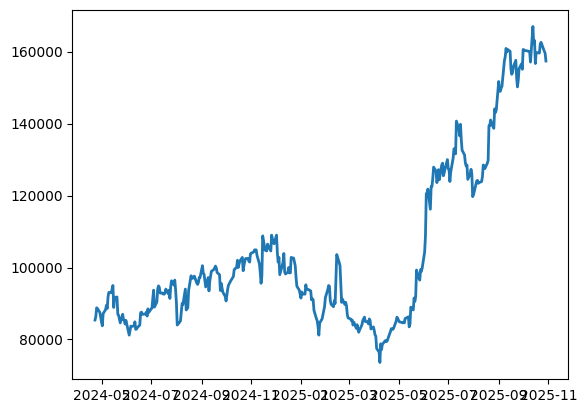

In [12]:
# 9) 시각화: 실제 vs 예측
plt.figure()
plt.plot(y_test.index, y_test.values, label='Actual', linewidth=2)
plt.plot(arima_pred_series.index, arima_pred_series.values, label='ARIMA Pred', linestyle='--')
plt.plot(rf_pred_series.index, rf_pred_series.values, label='RF Pred', linestyle=':')
plt.title(f"{leader} Actual vs Predicted (Test period)")
plt.legend()
plt.show()

# 10) 향후 N일 예측 (간단한 방법)
# - ARIMA는 직접 향후 horizon 예측 가능.
future_arima = arima_model.predict(n_periods=forecast_horizon)
last_date = df.index.max()
future_index = pd.bdate_range(last_date + pd.Timedelta(days=1), periods=forecast_horizon)
future_arima_series = pd.Series(future_arima, index=future_index)

plt.figure()
plt.plot(df['Close'].last('252'), label='Recent Close')
plt.plot(future_arima_series, label=f'ARIMA Forecast ({forecast_horizon}d)')
plt.title(f"{leader} Future Forecast (ARIMA)")
plt.legend()
plt.show()

# 11) 결과 저장
out_df = pd.DataFrame({
    "actual_test": y_test,
    "arima_pred": arima_pred_series,
    "rf_pred": rf_pred_series
})
out_df.to_csv(f"{leader}_test_results.csv")
future_arima_series.to_csv(f"{leader}_future_ARIMA.csv")
print("Results saved to CSV.")

# 12) 모델 저장(선택)
joblib.dump(rf, f"{leader}_rf_model.joblib")
joblib.dump(arima_model, f"{leader}_arima_model.joblib")
print("Models saved.")

# 끝
